# Prediction of House Sale Price in Boston

In [ ]:
# Проект построен следующим образом.
# Сначала определяются ф-ции, для последующего запуска генетического алгоритма по подбору оптимальных
# гиперпараметров для модели регрессии XGBoost (градиентного бустинга)
# 1. Data Parsing - обработка сырых данных:
# 1.1 Очистка данных
# 1.2 Определение ф-ций для последующей трансформации категориальных признаков, а также разделения некоторых числовых
# 1.3 Проведение непосредственно самой трансформации/разделения признаков
# 2. Применение линейной регрессионной модели ElasticNet с предварительным подбором гиперпараметров
# 3. Применение регрессора XGBoost
# 3.0 Подбор гиперпараметров вручную
# 3.1 Подбор гиперпараметров на основе генетического алгоритма (точность по кросс-валидации 89% против 86% default)
# 4. Применение модели регрессии RandomForest (макс. точность 85%)
# 4. Применение модели регрессии BaggingRegressor (точность 84%)
# 4. Применение модели регрессии Support Vector Regressor (точность 83%)
#
# В итоге регрессор XGBoost с подбором гиперпараметров при помощи генетического алгоритма показал максимальную точность
# 89% по кросс-валидации

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn import ensemble, model_selection, metrics, tree
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from numpy.random import randint
from numpy.random import randn,random
import random as rnd

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import warnings

%matplotlib inline

# Define functions for further Genetics run

In [109]:
'''
    Function of getting of the survived botes of the population
        Input parameters:
        - popul - the population
        - val - the current values of the prediction error MAE on the botes for the population
        - nsurv - the number of the survived botes
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        ):
    newpopul = [] # 2-dimension matrix for new population
    sval = sorted(val, reverse=1) # Sort the val-values on descending
    for i in range(nsurv): # Finally, the best nsurv-botes will be written in a new population 'newpopul'
        index = val.index(sval[i]) # Get the index in list 'val' for the value=sval[i]
        newpopul.append(popul[index]) # Add the bote from the current population with the founded above index in a new population
    return newpopul, sval # Return new population ('nsurv' elements) and the sorted list of function's result on the all the initial botes

'''
    Function to get parents from the survived botes of the population
        Input parameters:
        - curr_popul - the current survived population
        - nsurv - the number of survived botes
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = rnd.randint(0, nsurv - 1) # The random index of the first parent from 0 to 'nsurv - 1'
    indexp2 = rnd.randint(0, nsurv - 1) # The random index of the second parent from 0 to 'nsurv - 1'    
    botp1 = curr_popul[indexp1] # Get the first parent-bote based on index 'indexp1'
    botp2 = curr_popul[indexp2] # Get the second parent-bote based on index 'indexp2'    
    return botp1, botp2 # Return the both parents-botes

'''
    Function of crossing of two parents
        Input parameters:
        - botp1 - the first parent-bote
        - botp2 - the second parent-bote
        - j - number of the feature
'''
def crossPointFrom2Parents(
        botp1,
        botp2, 
        j
        ):
    pindex = rnd.random() # random number from 0 to 1
    if pindex < 0.5:
        x = botp1[j]
    else:
        x = botp2[j]
    return x

In [110]:
'''
    Function of initialization of population of botes. Each bote contents 6 hyperparameters of XGBoost model:

    n_estimators - the number of trees
    learning_rate - gradient step
    max_depth - max depth of the each tree (increasing this value will make the model more complex and more likely to 
                overfit)
    gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, 
            the more conservative the algorithm will be
    min_child_weight - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results 
                       in a leaf node with the sum of instance weight less than min_child_weight, then the building process 
                       will give up further partitioning. In linear regression task, this simply corresponds to minimum 
                       number of instances needed to be in each node. The larger min_child_weight is, the more conservative 
                       the algorithm will be.
    subsample - ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the 
                training data prior to growing trees and this will prevent overfitting. Subsampling will occur once in 
                every boosting iteration.
'''
def initilialize_poplulation(num_botes):
    learningRate = np.empty([num_botes, 1])
    nEstimators = np.empty([num_botes, 1], dtype = np.uint8)
    maxDepth = np.empty([num_botes, 1], dtype = np.uint8)
    minChildWeight = np.empty([num_botes, 1])
    gammaValue = np.empty([num_botes, 1])
    subSample = np.empty([num_botes, 1])
    for i in range(num_botes):
        learningRate[i] = round(rnd.uniform(0.01, 1), 2)
        nEstimators[i] = rnd.randrange(10, 1500, step = 25)
        maxDepth[i] = int(rnd.randrange(1, 10, step= 1))
        minChildWeight[i] = round(rnd.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(rnd.uniform(0.01, 10.0), 2)
        subSample[i] = round(rnd.uniform(0.01, 1.0), 2)
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample), axis= 1)
    return population

In [111]:
'''
    Function of mutation
        Input parameters:
            param_n - feature index
            param_val - the value of the feature
            num_of_pars - the number of features in each bote
'''
def mutation(param_n,param_val,num_of_pars):
    #the borders for the each feature
    minMaxValue = np.zeros((num_of_pars, 2))
    minMaxValue[0, :] = [0.01, 1.0] #min/max learning rate
    minMaxValue[1, :] = [10, 2000] #min/max n_estimator
    minMaxValue[2, :] = [1, 15] #min/max depth
    minMaxValue[3, :] = [0, 10.0] #min/max child_weight
    minMaxValue[4, :] = [0.01, 10.0] #min/max gamma
    minMaxValue[5, :] = [0.01, 1.0] #min/max subsample
 
    # First set the change of the feature
    if param_n == 0: #learning_rate
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if param_n == 1: #n_estimators
        mutationValue = np.random.randint(-200, 200)
    if param_n == 2: #max_depth
        mutationValue = np.random.randint(-5, 5)
    if param_n == 3: #min_child_weight
        mutationValue = round(np.random.uniform(5, 5), 2)
    if param_n == 4: #gamma
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if param_n == 5: #subsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    # new feature value = old feature value + change of the feature
    mutated_param = param_val + mutationValue
    # keep the new feature value within the borders
    if(mutated_param > minMaxValue[param_n, 1]):
        mutated_param = minMaxValue[param_n, 1]
    if(mutated_param < minMaxValue[param_n, 0]):
        mutated_param = minMaxValue[param_n, 0]      
    return mutated_param

# 1. Data Parsing

In [112]:
data = pd.read_csv('Data\houses_train.csv', sep=',')
data_test = pd.read_csv('Data\houses_test.csv', sep=',')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.1 Data Cleaning

In [4]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
data_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


###### 1.1.1 LotFrontage (Linear feet of street connected to property)

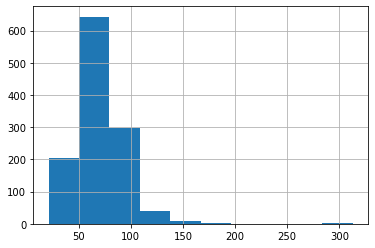

In [113]:
data.LotFrontage.hist()
# Replace all NaN values of LotFrontage to the mean value
data['LotFrontage'] = data['LotFrontage'].fillna((data['LotFrontage'].mean()))
data_test['LotFrontage'] = data_test['LotFrontage'].fillna((data_test['LotFrontage'].mean()))

###### 1.1.2 MasVnrArea (Masonry veneer area in square feet)

In [114]:
data[data.MasVnrArea.isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [115]:
# As MasVnrArea is always NaN when the house has no corresponding type, replace MasVnrArea to 0
data['MasVnrArea'] = data['MasVnrArea'].fillna(0.0)
data_test['MasVnrArea'] = data_test['MasVnrArea'].fillna(0.0)

###### 1.1.3 GarageYrBlt (Year garage was built)

In [116]:
# Replace NaN GarageYrBlt to the earliest year - 1900
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(1900)
data_test['GarageYrBlt'] = data_test['GarageYrBlt'].fillna(1900)

###### 1.1.4 Replace (BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars, GarageArea) NaN to 0

In [117]:
data_test['BsmtFinSF1'] = data_test['BsmtFinSF1'].fillna(0.0)
data_test['BsmtFinSF2'] = data_test['BsmtFinSF2'].fillna(0.0)
data_test['BsmtUnfSF'] = data_test['BsmtUnfSF'].fillna(0.0)
data_test['TotalBsmtSF'] = data_test['TotalBsmtSF'].fillna(0.0)
data_test['BsmtFullBath'] = data_test['BsmtFullBath'].fillna(0.0)
data_test['BsmtHalfBath'] = data_test['BsmtHalfBath'].fillna(0.0)
data_test['GarageCars'] = data_test['GarageCars'].fillna(0.0)
data_test['GarageArea'] = data_test['GarageArea'].fillna(0.0)

###### 1.1.5 MasVnrType - Replace NaN to the existing 'None' category

In [118]:
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data_test['MasVnrType'] = data_test['MasVnrType'].fillna('None')

###### 1.1.6 FullBath (Full bathrooms above grade)

In [119]:
print('Unique train data')
print(data.FullBath.unique())
print('Unique test data before transformation')
print(data_test.FullBath.unique())

# As train data values have maximum 3 - replace 4 in test data to 3

data_test.loc[data_test['FullBath'] > 3, 'FullBath'] = 3
print('Unique test data after transformation')
print(data_test.FullBath.unique())

Unique train data
[2 1 3 0]
Unique test data before transformation
[1 2 3 4 0]
Unique test data after transformation
[1 2 3 0]


###### 1.1.7 Typo errors fixing in 'Exterior2nd' column

In [120]:
print('Before fixing:')
print('Exterior1st(train):',list(data.Exterior1st.unique()))
print('Exterior2nd(train):',list(data.Exterior2nd.unique()))
print('Exterior1st(test):',list(data_test.Exterior1st.unique()))
print('Exterior2nd(test):',list(data_test.Exterior2nd.unique()))

# Fix the values in Exterior2nd 'Wd Shng' to 'WdShing', 'Brk Cmn' to 'BrkComm' and 'CmentBd' to 'CemntBd

data.loc[data['Exterior2nd'] == 'Wd Shng', 'Exterior2nd'] = 'WdShing'
data_test.loc[data_test['Exterior2nd'] == 'Wd Shng', 'Exterior2nd'] = 'WdShing'
data.loc[data['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd'] = 'BrkComm'
data_test.loc[data_test['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd'] = 'BrkComm'
data.loc[data['Exterior2nd'] == 'CmentBd', 'Exterior2nd'] = 'CemntBd'
data_test.loc[data_test['Exterior2nd'] == 'CmentBd', 'Exterior2nd'] = 'CemntBd'

# Replace the nan values in 'Exterior1st' and 'Exterior2nd' for data_test to 'Other' value

data_test['Exterior1st'] = data_test['Exterior1st'].fillna('Other')
data_test['Exterior2nd'] = data_test['Exterior2nd'].fillna('Other')
print('\n','After fixing:')
print('Exterior2nd(train):',list(data.Exterior2nd.unique()))
print('Exterior2nd(test):',list(data_test.Exterior2nd.unique()))

# In the function body which will be introduced further we will use data_train.Exterior2nd.unique() as it contains 
# also 'Other' value versus 'data_train.Exterior1st.unique()'

Before fixing:
Exterior1st(train): ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock']
Exterior2nd(train): ['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock']
Exterior1st(test): ['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd', 'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn', nan, 'CBlock']
Exterior2nd(test): ['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'Brk Cmn', 'CmentBd', 'ImStucc', 'Wd Shng', 'AsbShng', 'Stucco', 'CBlock', 'BrkFace', 'AsphShn', nan, 'Stone']

 After fixing:
Exterior2nd(train): ['VinylSd', 'MetalSd', 'WdShing', 'HdBoard', 'Plywood', 'Wd Sdng', 'CemntBd', 'BrkFace', 'Stucco', 'AsbShng', 'BrkComm', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock']
Exterior2nd(test): ['VinylSd', 'Wd Sdng', 'HdBoard', 

### 1.2 Functions for data transformation

In [121]:
# Transform each categorical column to multiple columns
def to_categorical(arg,vect_len):
    vect = np.zeros(vect_len)
    vect[int(arg)] = 1.0
    return vect

###### 1.2.1 Function to transfer data to categorial

In [122]:
#d - input original value (string)
#dVar - np-array of all variants for that data
def categ_trans(d, dVar):
    dVar = list(dVar)
    #Find an index of the value in all variants array
    if d in dVar:
        ind = dVar.index(d)
        #one hot encoding
        ind = to_categorical(ind, len(dVar))
    else:
        ind = np.zeros(len(dVar))
    return ind

###### 1.2.2 Function to transfer multiple-choice data to categorial

In [123]:
def categ_mult_trans(d,dVar):
    dVar = list(dVar)
    vect = np.zeros(len(dVar))
    for val in d:
        vect[dVar.index(val)] = 1
    return vect

###### 1.2.3 Function to transfer original construction date (YearBuilt) into several categories

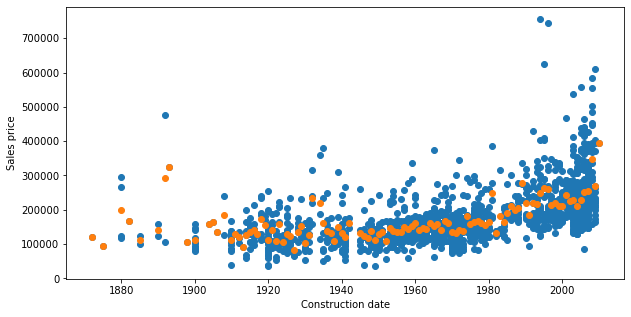

In [124]:
#First, look on the data
plt.figure(figsize=(10,5))

# mean sale price within each construstion year
y_mean = []
x_mean = list(data.YearBuilt.unique())
for year in x_mean:
    y_mean.append(data[data.YearBuilt == year].SalePrice.mean())

y = data.SalePrice
x = data.YearBuilt
plt.scatter(x, y)
plt.scatter(x_mean, y_mean)
plt.xlabel('Construction date')
plt.ylabel('Sales price')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# According to the graph below, let's create the following 13 categories
def year_categ(year):
    if year <= 1900:
        return [1.0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (year >= 1901) & (year <= 1930):
        return [0,1.0,0,0,0,0,0,0,0,0,0,0,0]
    if (year >= 1931) & (year <= 1950):
        return [0,0,1.0,0,0,0,0,0,0,0,0,0,0]
    if (year >= 1951) & (year <= 1957):
        return [0,0,0,1.0,0,0,0,0,0,0,0,0,0]
    if (year >= 1958) & (year <= 1967):
        return [0,0,0,0,1.0,0,0,0,0,0,0,0,0]
    if (year >= 1968) & (year <= 1972):
        return [0,0,0,0,0,1.0,0,0,0,0,0,0,0]
    if (year >= 1973) & (year <= 1975):
        return [0,0,0,0,0,0,1.0,0,0,0,0,0,0]
    if (year >= 1976) & (year <= 1981):
        return [0,0,0,0,0,0,0,1.0,0,0,0,0,0]
    if (year >= 1982) & (year <= 1985):
        return [0,0,0,0,0,0,0,0,1.0,0,0,0,0]
    if (year >= 1986) & (year <= 1989):
        return [0,0,0,0,0,0,0,0,0,1.0,0,0,0]
    if (year >= 1990) & (year <= 1999):
        return [0,0,0,0,0,0,0,0,0,0,1.0,0,0]
    if (year >= 2000) & (year <= 2006):
        return [0,0,0,0,0,0,0,0,0,0,0,1.0,0]
    if year >= 2007:
        return [0,0,0,0,0,0,0,0,0,0,0,0,1.0]

###### 1.2.4 Function to transfer Remodel date (YearRemodAdd) into several categories

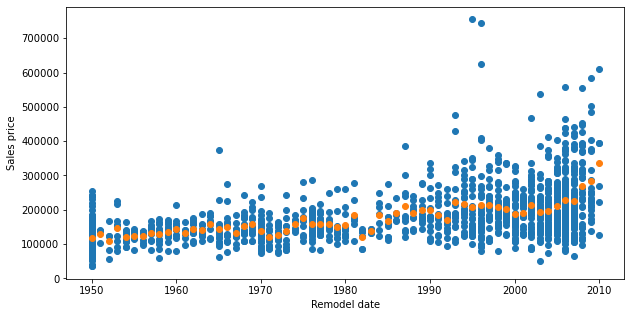

In [125]:
#First, look on the data
plt.figure(figsize=(10,5))

# mean sale price within each remodel year
y_mean = []
x_mean = list(data.YearRemodAdd.unique())
for year in x_mean:
    y_mean.append(data[data.YearRemodAdd == year].SalePrice.mean())

y = data.SalePrice
x = data.YearRemodAdd
plt.scatter(x, y)
plt.scatter(x_mean, y_mean)
plt.xlabel('Remodel date')
plt.ylabel('Sales price')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# According to the graph below, let's create the following 4 categories
def Ryear_categ(year):
    if year <= 1980:
        return [1.0,0,0,0]
    if (year >= 1981) & (year <= 1990):
        return [0,1.0,0,0]
    if (year >= 1991) & (year <= 2000):
        return [0,0,1.0,0]
    if year >= 2001:
        return [0,0,0,1.0]

###### 1.2.5 Function to transfer Total rooms above grade excluding bathrooms (TotRmsAbvGrd) into several categories

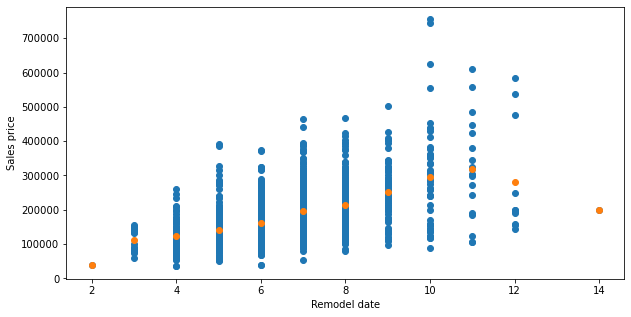

In [126]:
#First, look on the data
plt.figure(figsize=(10,5))

# mean sale price within each number of rooms
y_mean = []
x_mean = list(np.sort(data.TotRmsAbvGrd.unique()))
for room in x_mean:
    y_mean.append(data[data.TotRmsAbvGrd == room].SalePrice.mean())

y = data.SalePrice
x = data.TotRmsAbvGrd
plt.scatter(x, y)
plt.scatter(x_mean, y_mean)
plt.xlabel('Remodel date')
plt.ylabel('Sales price')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# According to the graph below, let's create the following 10 categories
def Rooms_categ(room):
    if room == 2:
        return [1.0,0,0,0,0,0,0,0,0,0]
    if room == 3 or room == 4:
        return [0,1.0,0,0,0,0,0,0,0,0]
    if room == 5:
        return [0,0,1.0,0,0,0,0,0,0,0]
    if room == 6:
        return [0,0,0,1.0,0,0,0,0,0,0]
    if room == 7:
        return [0,0,0,0,1.0,0,0,0,0,0]
    if room == 8:
        return [0,0,0,0,0,1.0,0,0,0,0]
    if room == 9:
        return [0,0,0,0,0,0,1.0,0,0,0]
    if room == 10:
        return [0,0,0,0,0,0,0,1.0,0,0]
    if room == 11:
        return [0,0,0,0,0,0,0,0,1.0,0]
    if room >= 12:
        return [0,0,0,0,0,0,0,0,0,1.0]

###### 1.2.6 Function to transfer Number of fireplaces (Fireplaces) into several categories

In [127]:
def Fire_categ(arg):
    if arg == 0:
        return [1.0, 0, 0, 0]
    if arg == 1:
        return [0, 1.0, 0, 0]
    if arg == 2:
        return [0, 0, 1.0, 0]
    if arg >= 3:
        return [0, 0, 0, 1.0]

###### 1.2.7 Function to transfer Year garage was built (GarageYrBlt) into several categories

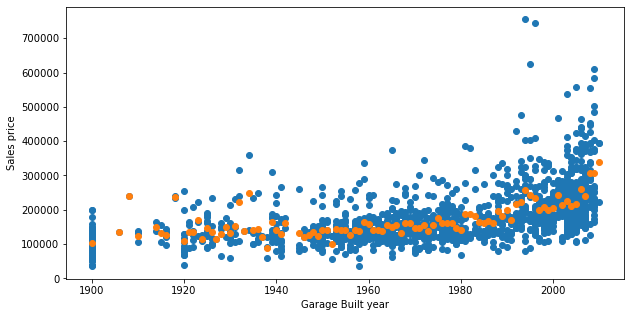

In [128]:
#First, look on the data
plt.figure(figsize=(10,5))

# mean sale price within each remodel year
y_mean = []
x_mean = list(data.GarageYrBlt.unique())
for year in x_mean:
    y_mean.append(data[data.GarageYrBlt == year].SalePrice.mean())

y = data.SalePrice
x = data.GarageYrBlt
plt.scatter(x, y)
plt.scatter(x_mean, y_mean)
plt.xlabel('Garage Built year')
plt.ylabel('Sales price')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# According to the graph below, let's create the following 6 categories
def Gar_year_categ(year):
    if year <= 1960:
        return [1.0,0,0,0,0,0]
    if (year >= 1961) & (year <= 1980):
        return [0,1.0,0,0,0,0]
    if (year >= 1981) & (year <= 1990):
        return [0,0,1.0,0,0,0]
    if (year >= 1991) & (year <= 2000):
        return [0,0,0,1.0,0,0]
    if (year >= 2001) & (year <= 2005):
        return [0,0,0,0,1.0,0]
    if year >= 2006:
        return [0,0,0,0,0,1.0]

###### 1.2.8 Function to transfer Size of garage in car capacity (GarageCars) into several categories

In [129]:
def Gar_car_categ(arg):
    if arg == 0:
        return [1.0, 0, 0, 0, 0]
    if arg == 1:
        return [0, 1.0, 0, 0, 0]
    if arg == 2:
        return [0, 0, 1.0, 0, 0]
    if arg == 3:
        return [0, 0, 0, 1.0, 0]
    if arg > 3:
        return [0, 0, 0, 0, 1.0]

##### 1.2.9 Function to join all transformed parameters together

In [130]:
def getAllParameters(d):
    MSSubClass = categ_trans(d.MSSubClass,data.MSSubClass.unique())
    MSZoning = categ_trans(d.MSZoning,data.MSZoning.unique())
    Street = categ_trans(d.Street,data.Street.unique())
    Alley = categ_trans(d.Alley,data.Alley.unique())
    LotShape = categ_trans(d.LotShape,data.LotShape.unique())
    LandContour = categ_trans(d.LandContour,data.LandContour.unique())
    Utilities = categ_trans(d.Utilities,data.Utilities.unique())
    LotConfig = categ_trans(d.LotConfig,data.LotConfig.unique())
    LandSlope = categ_trans(d.LandSlope,data.LandSlope.unique())
    Neighborhood = categ_trans(d.Neighborhood,data.Neighborhood.unique())
    Condition = categ_mult_trans([d.Condition1] + [d.Condition2],data.Condition1.unique())
    BldgType  = categ_trans(d.BldgType,data.BldgType.unique())
    HouseStyle = categ_trans(d.HouseStyle,data.HouseStyle.unique())
    OverallQual = categ_trans(d.OverallQual,np.sort(data.OverallQual.unique()))
    OverallCond = categ_trans(d.OverallCond,np.sort(data.OverallCond.unique()))
    YearBuilt = year_categ(d.YearBuilt)
    YearRemodAdd = Ryear_categ(d.YearRemodAdd)
    RoofStyle = categ_trans(d.RoofStyle,data.RoofStyle.unique())
    RoofMatl = categ_trans(d.RoofMatl,data.RoofMatl.unique())
    Exterior = categ_mult_trans([d.Exterior1st] + [d.Exterior2nd],data.Exterior2nd.unique())
    MasVnrType = categ_trans(d.MasVnrType,data.MasVnrType.unique())
    ExterQual = categ_trans(d.ExterQual,data.ExterQual.unique())
    ExterCond = categ_trans(d.ExterCond,data.ExterCond.unique())
    Foundation = categ_trans(d.Foundation,data.Foundation.unique())
    BsmtQual = categ_trans(d.BsmtQual,data.BsmtQual.unique())
    BsmtCond = categ_trans(d.BsmtCond,data.BsmtCond.unique())
    BsmtExposure = categ_trans(d.BsmtExposure,data.BsmtExposure.unique())
    BsmtFinType1 = categ_trans(d.BsmtFinType1,data.BsmtFinType1.unique())
    BsmtFinType2 = categ_trans(d.BsmtFinType2,data.BsmtFinType2.unique())
    Heating = categ_trans(d.Heating,data.Heating.unique())
    HeatingQC = categ_trans(d.HeatingQC,data.HeatingQC.unique())
    CentralAir = categ_trans(d.CentralAir,data.CentralAir.unique())
    Electrical = categ_trans(d.Electrical,data.Electrical.unique())
    BsmtFullBath = categ_trans(d.BsmtFullBath,np.sort(data.BsmtFullBath.unique()))
    BsmtHalfBath = categ_trans(d.BsmtHalfBath,np.sort(data.BsmtHalfBath.unique()))
    FullBath = categ_trans(d.FullBath,np.sort(data.FullBath.unique()))
    HalfBath = categ_trans(d.HalfBath,np.sort(data.HalfBath.unique()))
    BedroomAbvGr = categ_trans(d.BedroomAbvGr,np.sort(data.BedroomAbvGr.unique()))
    KitchenAbvGr = categ_trans(d.KitchenAbvGr,np.sort(data.KitchenAbvGr.unique()))
    KitchenQual = categ_trans(d.KitchenQual,data.KitchenQual.unique())
    TotRmsAbvGrd = Rooms_categ(d.TotRmsAbvGrd)
    Functional = categ_trans(d.Functional,data.Functional.unique())
    Fireplaces = Fire_categ(d.Fireplaces)
    FireplaceQu = categ_trans(d.FireplaceQu,data.FireplaceQu.unique())
    GarageType = categ_trans(d.GarageType,data.GarageType.unique())
    GarageYrBlt = Gar_year_categ(d.GarageYrBlt)
    GarageFinish = categ_trans(d.GarageFinish,data.GarageFinish.unique())
    GarageCars = Gar_car_categ(d.GarageCars)
    GarageQual = categ_trans(d.GarageQual,data.GarageQual.unique())
    GarageCond = categ_trans(d.GarageCond,data.GarageCond.unique())
    PavedDrive = categ_trans(d.PavedDrive,data.PavedDrive.unique())
    PoolQC = categ_trans(d.PoolQC,data.PoolQC.unique())
    Fence = categ_trans(d.Fence,data.Fence.unique())
    MiscFeature = categ_trans(d.MiscFeature,data.MiscFeature.unique())
    MiscVal = categ_trans(d.MiscVal,data.MiscVal.unique())
    MoSold = categ_trans(d.MoSold,data.MoSold.unique())
    YrSold = categ_trans(d.YrSold,np.sort(data.YrSold.unique()))
    SaleType = categ_trans(d.SaleType,data.SaleType.unique())
    SaleCondition = categ_trans(d.SaleCondition,data.SaleCondition.unique())

    out = list(MSSubClass)
    out.extend(MSZoning)
    out.append(d.LotFrontage)
    out.append(d.LotArea)
    out.extend(Street)
    out.extend(Alley)
    out.extend(LotShape)
    out.extend(LandContour)
    out.extend(Utilities)
    out.extend(LotConfig)
    out.extend(LandSlope)
    out.extend(Neighborhood)
    out.extend(Condition)
    out.extend(BldgType)
    out.extend(HouseStyle)
    out.extend(OverallQual)
    out.extend(OverallCond)
    out.extend(YearBuilt)
    out.extend(YearRemodAdd)
    out.extend(RoofStyle)
    out.extend(RoofMatl)
    out.extend(Exterior)
    out.extend(MasVnrType)
    out.append(d.MasVnrArea)
    out.extend(ExterQual)
    out.extend(ExterCond)
    out.extend(Foundation)
    out.extend(BsmtQual)
    out.extend(BsmtCond)
    out.extend(BsmtExposure)
    out.extend(BsmtFinType1)
    out.append(d.BsmtFinSF1)
    out.extend(BsmtFinType2)
    out.append(d.BsmtFinSF2)
    out.append(d.BsmtUnfSF)
    out.append(d.TotalBsmtSF)
    out.extend(Heating)
    out.extend(HeatingQC)
    out.extend(CentralAir)
    out.extend(Electrical)
    out.append(d['1stFlrSF'])
    out.append(d['2ndFlrSF'])
    out.append(d.LowQualFinSF)
    out.append(d.GrLivArea)
    out.extend(BsmtFullBath) 
    out.extend(BsmtHalfBath)
    out.extend(FullBath)
    out.extend(HalfBath)
    out.extend(BedroomAbvGr)
    out.extend(KitchenAbvGr)
    out.extend(KitchenQual)
    out.extend(TotRmsAbvGrd)
    out.extend(Functional)
    out.extend(Fireplaces)
    out.extend(FireplaceQu)
    out.extend(GarageType)
    out.extend(GarageYrBlt)
    out.extend(GarageFinish)
    out.extend(GarageCars)
    out.append(d.GarageArea)
    out.extend(GarageQual)
    out.extend(GarageCond)
    out.extend(PavedDrive)
    out.append(d.WoodDeckSF)
    out.append(d.OpenPorchSF)
    out.append(d.EnclosedPorch)
    out.append(d['3SsnPorch'])
    out.append(d.ScreenPorch)
    out.append(d.PoolArea)
    out.extend(PoolQC)
    out.extend(Fence)
    out.extend(MiscFeature)
    out.extend(MiscVal)
    out.extend(MoSold)
    out.extend(YrSold)
    out.extend(SaleType)
    out.extend(SaleCondition)
    return out

In [131]:
# Check of the final function getAllParameters() which join all transformed parameters together

testlist = getAllParameters(data.iloc[2])
col_list = list(data.columns)
col_list.remove('Id')
#remove number-type noncategorial columns
col_list.remove('LotFrontage')
col_list.remove('LotArea')
col_list.remove('MasVnrArea')
col_list.remove('BsmtFinSF1')
col_list.remove('BsmtFinSF2')
col_list.remove('BsmtUnfSF')
col_list.remove('TotalBsmtSF')
col_list.remove('1stFlrSF')
col_list.remove('2ndFlrSF')
col_list.remove('LowQualFinSF')
col_list.remove('GrLivArea')
col_list.remove('GarageArea')
col_list.remove('WoodDeckSF')
col_list.remove('OpenPorchSF')
col_list.remove('EnclosedPorch')
col_list.remove('3SsnPorch')
col_list.remove('ScreenPorch')
col_list.remove('PoolArea')
#remove double columns
col_list.remove('Condition2')
col_list.remove('Exterior1st')
#remove columns where the original data was transformed to categorial
col_list.remove('FullBath')
col_list.remove('YearBuilt')
col_list.remove('YearRemodAdd')
col_list.remove('TotRmsAbvGrd')
col_list.remove('Fireplaces')
col_list.remove('GarageYrBlt')
col_list.remove('GarageCars')
#remove the target column
col_list.remove('SalePrice')

# Removed colums give the total dimension:
add_dim = 18 + 4 + 13 + 4 + 10 + 4 + 6 + 5
# Calculate the total dimension of the rest columns
dim = 0
for col in col_list:
    dim += data[col].unique().shape[0]
# Are the dimensions the same?
dim+add_dim == len(testlist)

True

### 1.3 Make the transformation of all the data

In [24]:
# X,y    = data taken from data_train.csv
# X_pred = data taken from data_test.csv

In [132]:
%%time
i = 0
X = []
X_pred = []
for i in range(max(data.shape[0],data_test.shape[0])):
    if i < data.shape[0]:
        X.append(getAllParameters(data.iloc[i]))
    if i < data_test.shape[0]:
        X_pred.append(getAllParameters(data_test.iloc[i]))
    i += 1

# Make a column of the target feature
y = data.SalePrice

print(len(X[123]))
print(len(X_pred[123]))

402
402
Wall time: 44.6 s


In [133]:
# Split the data which are targeted for building a model into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 2)

In [134]:
# Normalization of the data
xScaler = StandardScaler()
xScaler.fit(X_train)
X_train_scl = xScaler.transform(X_train)
X_test_scl = xScaler.transform(X_test)
X_scl = xScaler.transform(X)

yScaler = StandardScaler()
yScaler.fit(np.array(y_train).reshape(-1,1))
y_train_scl = yScaler.transform(np.array(y_train).reshape(-1,1)).flatten()
y_test_scl = yScaler.transform(np.array(y_test).reshape(-1,1)).flatten()
y_scl = yScaler.transform(np.array(y).reshape(-1,1)).flatten()

In [135]:
print("The mean value of some standartized column of X-matrix: ",np.mean(X_test_scl[:,10]))
print("The mean value of standartized y: ",np.mean(y_test_scl))
print("The standard deviation of some standartized column of X-matrix: ",np.std(X_test_scl[:,10]))
print("The standard deviation of standartized y: ",np.std(y_test_scl))

The mean value of some standartized column of X-matrix:  -0.013069817382308425
The mean value of standartized y:  0.059598526916780366
The standard deviation of some standartized column of X-matrix:  0.968852710487984
The standard deviation of standartized y:  1.0315398340950754


# 2. Linear Regression Model: ElasticNet

In [29]:
%%time
warnings.filterwarnings('ignore')
# Fit the optimal model parameters
alphas = np.arange(0.1,1.1,0.1)
l1_ratios = np.arange(0.0,1.1,0.1)
min_err = np.inf
for alpha in alphas:
    for L1r in l1_ratios:
        regressor = ElasticNet(alpha=alpha, l1_ratio=L1r)
        regressor.fit(X_train_scl, y_train_scl)
        prediction = regressor.predict(X_test_scl)
        # denormalization of the prediction
        y_predict = yScaler.inverse_transform(prediction).flatten()
        # prediction error          
        diff = np.abs(y_predict - y_test)
        pred_err = diff.sum()
        if pred_err < min_err:
            min_err = pred_err
            best_par = [alpha, L1r]
            best_model = regressor
        print("Alpha: {:.1f}, L1 ratio: {:.1f}, prediction abs error: {:.0f}".format(alpha,L1r,pred_err))

Alpha: 0.1, L1 ratio: 0.0, prediction abs error: 5170616
Alpha: 0.1, L1 ratio: 0.1, prediction abs error: 4644658
Alpha: 0.1, L1 ratio: 0.2, prediction abs error: 4845803
Alpha: 0.1, L1 ratio: 0.3, prediction abs error: 5120904
Alpha: 0.1, L1 ratio: 0.4, prediction abs error: 5411775
Alpha: 0.1, L1 ratio: 0.5, prediction abs error: 5678355
Alpha: 0.1, L1 ratio: 0.6, prediction abs error: 5881080
Alpha: 0.1, L1 ratio: 0.7, prediction abs error: 6034451
Alpha: 0.1, L1 ratio: 0.8, prediction abs error: 6195397
Alpha: 0.1, L1 ratio: 0.9, prediction abs error: 6349726
Alpha: 0.1, L1 ratio: 1.0, prediction abs error: 6474628
Alpha: 0.2, L1 ratio: 0.0, prediction abs error: 5006101
Alpha: 0.2, L1 ratio: 0.1, prediction abs error: 4927920
Alpha: 0.2, L1 ratio: 0.2, prediction abs error: 5438480
Alpha: 0.2, L1 ratio: 0.3, prediction abs error: 5917311
Alpha: 0.2, L1 ratio: 0.4, prediction abs error: 6244207
Alpha: 0.2, L1 ratio: 0.5, prediction abs error: 6573557
Alpha: 0.2, L1 ratio: 0.6, pred

In [33]:
print("The best model of ElasticNet has alpha =",best_par[0],"and L1 ratio =",best_par[1])

The best model of ElasticNet has alpha = 0.1 and L1 ratio = 0.1


In [34]:
regressor = ElasticNet(alpha=best_par[0], l1_ratio=best_par[1], max_iter=10000)
regressor.fit(X_train_scl, y_train_scl)
# make prediction on the test dataset
prediction = regressor.predict(X_test_scl)
# prediction de-scaling
y_predict = yScaler.inverse_transform(prediction).flatten()

In [35]:
mean_price = np.mean(y_test)
mean_delta = np.mean(abs(y_predict - y_test))
print('The mean house price on the test dataset: ', round(mean_price))
print('The mean prediction error on the test dataset: ', round(mean_delta))
print('The mean relative error: ', round(100*mean_delta/mean_price), '%', sep='')

The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  15906
The mean relative error: 9%


In [36]:
# Predict on the estimated dataset 
X_pred_scl = xScaler.transform(X_pred)
y_pred_estimated_unscaled = regressor.predict(X_pred_scl)
y_pred_estimated = yScaler.inverse_transform(y_pred_estimated_unscaled).flatten()

In [35]:
# Put the result in file to upload to KAGGLE
Final_table = pd.DataFrame(columns=["Id","SalePrice"])
for i in range(1461,2920):
    Final_table.loc[i-1461] = [int(i), y_pred_estimated[i-1461]]
Final_table = Final_table.astype({"Id": int})
Final_table.set_index('Id',inplace=True)
Final_table.head()
Final_table.to_csv('Data\HousesSale_Regr.csv',sep=',',header=True)

,SalePrice
Id,
1461,123765.655348
1462,162727.703856
1463,188766.689191
1464,195219.206672
1465,209246.406694


# 3. The gradient boosting XGBoost

#### 3.0 Select the hyperparameters manually

In [37]:
%%time
# First seek the enough number of Trees

n_est = np.arange(20, 200, 10)
score = []
for n in n_est:
    print(n)
    est = xgb.XGBRegressor(max_depth=5, n_estimators=n)
    answer = model_selection.cross_val_predict(estimator=est, X=X_train_scl, y = y_train_scl, cv=5, n_jobs=-1, verbose=0)
    score.append(metrics.mean_squared_error(y_train_scl, answer)**0.5)

20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
Wall time: 2min 57s


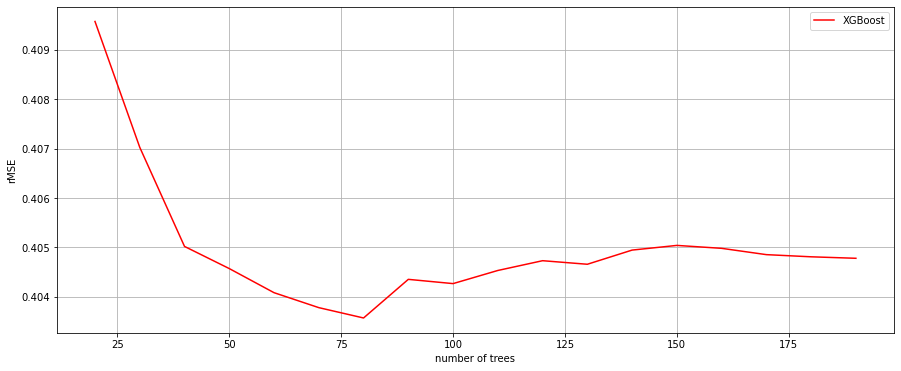

In [38]:
plt.figure(figsize=(15,6))
plt.plot(n_est, score, color='r', label="XGBoost")
plt.legend()
plt.xlabel("number of trees")
plt.ylabel("rMSE")
plt.grid()

In [39]:
# You can see that the optimal number of Trees is ~80

In [40]:
%%time
# Now seek the optimal depth on the selected above number of Trees
len = np.arange(2, 16, 2)
score = []
for d in len:
    print(d)
    est = xgb.XGBRegressor(max_depth=d, n_estimators=80)
    ans = model_selection.cross_val_predict(estimator=est, X=X_train_scl, y=y_train_scl, cv=10, n_jobs=-1, verbose=0)
    score.append(metrics.mean_squared_error(y_train, ans)**0.5)

2
4
6
8
10
12
14
Wall time: 2min 57s


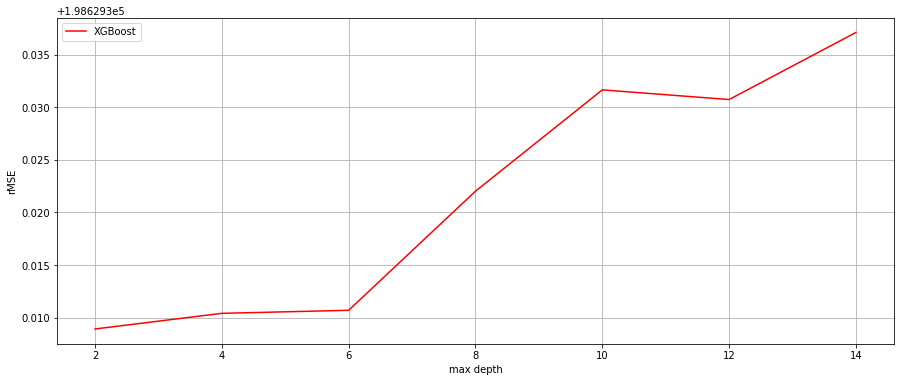

In [41]:
plt.figure(figsize=(15,6))
plt.plot(len, score, color='r', label="XGBoost")
plt.legend()
plt.xlabel("max depth")
plt.ylabel("rMSE")
plt.grid()

In [37]:
# early_stopping_rounds - overwork prevention: early break if there is no improvement
# learning_rate - control the input of each Tree in the ensamble
# subsample - the percentage of random subsample used for training of each Tree
def XGB_fit(max_depth=4, n_estimators=80, learning_rate = 0.12, subsample=1.0):
    XGB_opt = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate = learning_rate, subsample=subsample)
    XGB_opt.fit(X_train_scl, y_train_scl)
    prediction = XGB_opt.predict(X_test_scl)
    y_predict = yScaler.inverse_transform(prediction).flatten()

    mean_price = np.mean(y_test)
    mean_delta = np.mean(abs(y_predict - y_test))
    print('The mean house price on the test dataset: ', round(mean_price))
    print('The mean prediction error on the test dataset: ', round(mean_delta))
    print('The mean relative error: ', round(100*mean_delta/mean_price), '%', sep='')

In [38]:
# prediction de-scaling
for ss in np.arange(0.1,1.1,0.1):
    print("Subsample: {:.2f}".format(ss))
    XGB_fit(learning_rate = 0.09, subsample=ss)

Subsample: 0.10
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  19059
The mean relative error: 10%
Subsample: 0.20
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  18827
The mean relative error: 10%
Subsample: 0.30
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  19688
The mean relative error: 11%
Subsample: 0.40
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  18610
The mean relative error: 10%
Subsample: 0.50
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  17572
The mean relative error: 10%
Subsample: 0.60
The mean house price on the test dataset:  184683
The mean prediction error on the test dataset:  18506
The mean relative error: 10%
Subsample: 0.70
The mean house price on the test dataset:  184683
The mean prediction error on the test da

#### 3.1 Select hyperparameters based on Genetics

In [175]:
%%time
n = 40 # the population size
nsurv = int(0.2*n) # the size of the survived botes in population
nnew = n - nsurv # the number of new botes (after keeping the best 'nsurv' botes)
l = 6 # the length of bote (number of features)
epohs = 30 # number of epochs (how many times we change population)

popul = initilialize_poplulation(n) # Creates random population: [n, l] matrix

for it in range(epohs):
    val = [] # 1-dimension array of the model precision (or error for regression problem) on the botes features

    for i in range(n):
        bot = popul[i] # the current bote
    
        # run the model on the features from the current bote
        XGB_i = xgb.XGBRegressor(
            learning_rate=bot[0],
            n_estimators=int(bot[1]),
            max_depth=int(bot[2]),
            min_child_weight=bot[3],
            gamma=bot[4],
            subsample=bot[5])
        XGB_i.fit(X_train_scl, y_train_scl)
        
        #prediction = XGB_i.predict(X_test_scl)
        #y_predict = yScaler.inverse_transform(prediction).flatten()
        #val.append(round(mean_absolute_error(y_predict, y_test),1))
        
        # Make cross-validation of the builded model
        kfold = model_selection.KFold(n_splits=10,random_state=1,shuffle=True)
        K_results = model_selection.cross_val_score(XGB_i,X_scl,y_scl,cv=kfold)
        # calculate the mean accuracy on the cross-validation
        accuracy = np.mean(abs(K_results))
        if accuracy > 1:
            print('ups...accuracy=',accuracy)
            accuracy = 0.2
        # add the prediction score for the current bote based on cross-validation accuracy to the 'val' array
        val.append(round(accuracy,4))
    
    newpopul, sval = getSurvPopul(popul, val, nsurv) # Get the survived botes of population and sorted botes scores
    print(it, " ", [round(s,8) for s in sval[0:6]]) # print scores for 6 best botes
 
    for i in range(nnew): # run cycle 'n-nsurv' times to fill the rest of the new population based on the survived botes 
        botp1, botp2 = getParents(newpopul, nsurv) # Get from the survived botes-population two random parents
        newbot = [] # set new bote which will be borned from the choosen parents above
        # each feature of the new bote is crossing the features of the parents
        for j in range(l):
            # j-th feature of the new bote:
            x = crossPointFrom2Parents(botp1, botp2, j)        
            newbot.append(x)
        #Introduce mutation in a random feature of the borned bote
        j_mut = np.random.randint(0, l)
        newbot[j_mut] = mutation(j_mut,newbot[j_mut],l) 
        newpopul.append(newbot) # Add this bote in new population of the survived botes 
        #so we finally add 'n-nsurv' new borned botes to the survived botes
    
    popul = newpopul # Write the new created population in 'popul'

0   [0.8772, 0.8513, 0.8495, 0.8207, 0.8205, 0.8172]
1   [0.8772, 0.8631, 0.8573, 0.8523, 0.8513, 0.8495]
2   [0.8772, 0.8719, 0.8692, 0.8676, 0.8673, 0.8672]
3   [0.8772, 0.8754, 0.8753, 0.8749, 0.8742, 0.8736]
4   [0.8787, 0.8786, 0.8772, 0.8766, 0.8764, 0.8763]
5   [0.8787, 0.8786, 0.8781, 0.8779, 0.8773, 0.8772]
6   [0.8802, 0.8799, 0.8791, 0.8787, 0.8786, 0.8781]
7   [0.8837, 0.8815, 0.8813, 0.8802, 0.8799, 0.8793]
8   [0.8837, 0.8837, 0.8836, 0.8833, 0.8818, 0.8815]
9   [0.8837, 0.8837, 0.8837, 0.8836, 0.8833, 0.8829]
10   [0.8847, 0.8842, 0.8839, 0.8837, 0.8837, 0.8837]
11   [0.8847, 0.8846, 0.8842, 0.8839, 0.8838, 0.8837]
12   [0.885, 0.8847, 0.8846, 0.8846, 0.8846, 0.8842]
13   [0.885, 0.8849, 0.8847, 0.8846, 0.8846, 0.8846]
14   [0.8861, 0.8855, 0.885, 0.8849, 0.8847, 0.8846]
15   [0.8861, 0.8861, 0.8855, 0.885, 0.8849, 0.8847]
16   [0.8885, 0.8867, 0.8867, 0.8861, 0.8861, 0.8861]
17   [0.8885, 0.8867, 0.8867, 0.8867, 0.8861, 0.8861]
18   [0.8885, 0.8885, 0.8884, 0.8876, 0.88

In [176]:
#print the features of the best bote
best_bot = popul[0]
print("Learning rate = ",best_bot[0])
print("Trees number = ",best_bot[1])
print("Max depth = ",best_bot[2])
print("min_child_weight = ",best_bot[3])
print("gamma = ",best_bot[4])
print("subsample = ",best_bot[5])

Learning rate =  0.06
Trees number =  907.0
Max depth =  5.0
min_child_weight =  8.71
gamma =  0.01
subsample =  0.73


In [177]:
# run the model on the features of the best bote
XGB_best = xgb.XGBRegressor(
            learning_rate=best_bot[0],
            n_estimators=int(best_bot[1]),
            max_depth=int(best_bot[2]),
            min_child_weight=best_bot[3],
            gamma=best_bot[4],
            subsample=best_bot[5])
XGB_best.fit(X_train_scl, y_train_scl)

kfold = model_selection.KFold(n_splits=10,random_state=1,shuffle=True)
K_results = model_selection.cross_val_score(XGB_best,X_scl,y_scl,cv=kfold)
accuracy = np.mean(abs(K_results))
print("Accuracy on cross-validation for the best model: ",accuracy)

Accuracy on cross-validation for the best model:  0.888770301559821


In [136]:
# run the model on the default features (for comparison)
XGB_default = xgb.XGBRegressor()
XGB_default.fit(X_train_scl, y_train_scl)

kfold = model_selection.KFold(n_splits=10,random_state=1,shuffle=True)
K_results = model_selection.cross_val_score(XGB_default,X_scl,y_scl,cv=kfold)
accuracy = np.mean(abs(K_results))
print("Accuracy on cross-validation for the default model: ",accuracy)

Точность по кросс-валидации:  0.8583988745747231


In [178]:
# Prediction on the data from KAGGLE competition
X_pred_scl = xScaler.transform(X_pred)
y_pred_estimated_unscaled = XGB_best.predict(X_pred_scl)
y_pred_estimated = yScaler.inverse_transform(y_pred_estimated_unscaled).flatten()
Final_table = pd.DataFrame(columns=["Id","SalePrice"])
for i in range(1461,2920):
    Final_table.loc[i-1461] = [int(i), y_pred_estimated[i-1461]]
Final_table = Final_table.astype({"Id": int})
Final_table.set_index('Id',inplace=True)
Final_table.head()

,SalePrice
Id,
1461,123965.960938
1462,169039.906250
1463,190272.546875
1464,193199.031250
1465,186994.890625


In [179]:
Final_table.to_csv('Data\HousesSale_XGB_gen.csv',sep=',',header=True)

# 4. RandomForest

In [176]:
# Ф-ция создания случайного бота (для мутаций)

# Создает м-цу: numberOfParents x 6 (6 - кол-во элементов бота)
# criterion - критерии ошибки для минимизации (в классификации “gini” и “entropy”)
# max_depth - максимальная глубина деревьев
# min_samples_leaf - ограничение на число объектов в листьях
# min_samples_split - минимальное число объектов, при котором выполняется расщепление
# max_features - число признаков для выбора расщепления
# n_estimators - число деревьев

def createRandomBot():
    maxfeatureslist = ['auto', 'sqrt','log2', None]
    criterionlist = ['mse', 'mae']
    
    maxFeatures = maxfeatureslist[int(rnd.randrange(0, 4, step= 1))]
    nEstimators = rnd.randrange(10, 1500, step = 25)
    maxDepth = int(rnd.randrange(1, 20, step= 1))
    minSamplesLeaf = rnd.randrange(4, 14, step = 1)
    minSamplesSplit = rnd.randrange(5, 15, step = 1)
    criterion = criterionlist[int(rnd.randrange(0, 2, step= 1))]
    bot = [maxFeatures, nEstimators, maxDepth, minSamplesLeaf, minSamplesSplit, criterion]
    return bot

In [194]:
%%time
n = 40 # Размер популяции
nsurv = int(0.2*n) # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv # Количество новых (столько новых ботов создается)
l = 6 # Длина бота
epohs = 20 # Количество эпох

popul = [] # Массив популяции
#Создаём случайных ботов
for i in range(n):
    popul.append(createRandomBot())
val = [] # Одномерный массив значений этих ботов

for it in range(epohs): # Пробегаемся по всем эпохам  
    val = [] # Создаем пустой список для значений ботов

    for i in range(n): # Проходим по всей длине популяции
        bot = popul[i] # Берем очередного бота
    
        # запускаем модель на параметрах текущего бота popul[i]
        #maxFeatures, nEstimators, maxDepth, minSamplesLeaf, minSamplesSplit, criterion
        RFR_i = ensemble.RandomForestRegressor(
            max_features=bot[0],
            n_estimators=bot[1],
            max_depth=bot[2],
            min_samples_leaf=bot[3],
            min_samples_split=bot[4],
            criterion=bot[5])
        RFR_i.fit(X_train_scl, y_train_scl)
        # делаем предсказания на тестовой выборке
        prediction = RFR_i.predict(X_test_scl)
        # денормализация предсказания
        y_predict = yScaler.inverse_transform(prediction).flatten()
        # добавляем ошибку предсказания в список на эпоху
        val.append(round(mean_absolute_error(y_predict, y_test),1))
    
    newpopul, sval = getSurvPopul(popul, val, nsurv) # Получаем новую популяцию и сортированный список значнией
    print(it, " ", [round(s,8) for s in sval[0:6]]) # Выводим значения ф-ции ошибки для 6-ти лучших ботов
 
    for i in range(nnew): # Проходимся в цикле nnew-раз 
        botp1, botp2 = getParents(newpopul, nsurv) # Из newpopul(новой популяции) получаем двух случайных родителей-ботов
        newbot = [] # Массив для нового бота
        # проходимся по длине бота и осуществляем смешивание/скрещивание от родителей
        for j in range(l): # Проходим по всей длине бота
            # Получаем значение для j-ого компонента бота
            x = crossPointFrom2Parents(botp1, botp2, j)        
            newbot.append(x) # Добавялем новое значение в бот
        
        #Создаем случайный дополнительный бот для мутаций
        bot4Mut = createRandomBot()
        #Вносим мутацию в случайную компоненту текущего бота
        j_mut = np.random.randint(0, l)
        newbot[j_mut] = bot4Mut[j_mut]
        
        newpopul.append(newbot) # Добавляем бота в новую популяцию 
        #(таким образом к nsurv-лучших ботов предыдующей популяции добавится nnew-новых ботов)
    
    popul = newpopul # Записываем в popul посчитанную новую популяцию

0   [20779.2, 20971.2, 21776.0, 21865.9, 22177.3, 22195.0]
1   [20770.8, 20840.0, 20952.1, 21018.8, 21028.7, 21033.4]
2   [20193.1, 20676.8, 20765.3, 20781.8, 20792.4, 20815.6]
3   [19707.3, 19715.0, 20668.5, 20763.3, 20805.6, 20815.5]
4   [19468.1, 19469.4, 19484.5, 19544.5, 19548.5, 19601.8]
5   [19455.6, 19474.4, 19494.9, 19534.5, 19536.9, 19579.2]
6   [19398.8, 19476.2, 19496.3, 19499.0, 19503.8, 19505.0]
7   [19472.3, 19483.0, 19488.5, 19497.6, 19508.8, 19518.2]
8   [19407.8, 19441.4, 19473.9, 19493.2, 19494.8, 19519.5]
9   [19377.2, 19390.1, 19413.6, 19447.7, 19483.3, 19489.2]
10   [19316.4, 19407.4, 19477.8, 19486.9, 19487.9, 19500.7]
11   [19373.2, 19392.5, 19416.4, 19444.2, 19458.9, 19506.8]
12   [19410.3, 19410.4, 19415.1, 19427.8, 19511.4, 19513.5]
13   [19330.6, 19344.4, 19372.8, 19416.2, 19428.1, 19445.2]
14   [19354.8, 19415.5, 19432.2, 19437.6, 19448.3, 19496.3]
15   [19395.5, 19397.5, 19432.5, 19451.2, 19462.1, 19499.2]
16   [19448.3, 19457.8, 19480.8, 19481.8, 19482.8,

In [195]:
best_bot = popul[0]
print("max_features = ",best_bot[0])
print("n_etimators = ",best_bot[1])
print("max_depth = ",best_bot[2])
print("min_samples_leaf = ",best_bot[3])
print("min_samples_split = ",best_bot[4])
print("criterion = ",best_bot[5])

max_features =  sqrt
n_etimators =  210
max_depth =  17
min_samples_leaf =  4
min_samples_split =  7
criterion =  mse


In [186]:
# Оценка модели на тестовых данных
#print("Точность на тренировочных данных: ",model.score(X_train_scl, y_train_scl))
#print("Точность на тестовых данных: ",model.score(X_test_scl, y_test_scl))

In [187]:
# Вычисление MSE
#y_test_pred = model.predict(X_test_scl)
#metrics.mean_squared_error(y_test_scl,y_test_pred)

In [196]:
# запускаем модель на параметрах наилучшего бота
RFR_best = ensemble.RandomForestRegressor(
            max_features=best_bot[0],
            n_estimators=best_bot[1],
            max_depth=best_bot[2],
            min_samples_leaf=best_bot[3],
            min_samples_split=best_bot[4],
            criterion=best_bot[5])
RFR_best.fit(X_train_scl, y_train_scl)

# Стандартизируем исходные данные для кросс-валидации
X_scl = xScaler.transform(X)
y_scl = yScaler.transform(np.array(y).reshape(-1,1)).flatten()

# Проводим кросс-валидацию построенной модели
k = 10
kfold = model_selection.KFold(n_splits=k,random_state=1,shuffle=True)
K_results = model_selection.cross_val_score(RFR_best,X_scl,y_scl,cv=kfold)
# и считаем точность по кросс-валидации
accuracy = np.mean(abs(K_results))
print("Точность по кросс-валидации: ",accuracy)

Точность по кросс-валидации:  0.8250211439050444


In [185]:
# для сравнения запускаем модель с параметрами по умолчанию
RFR_standard = ensemble.RandomForestRegressor()
RFR_standard.fit(X_train_scl, y_train_scl)

# Проводим кросс-валидацию построенной модели
K_results = model_selection.cross_val_score(RFR_standard,X_scl,y_scl,cv=kfold)
# и считаем точность по кросс-валидации
accuracy = np.mean(abs(K_results))
print("Точность по кросс-валидации: ",accuracy)

Точность по кросс-валидации:  0.8519049241394392


# 5. Bagging Regressor

In [215]:
# запускаем модель с параметрами по умолчанию
BR_standard = ensemble.BaggingRegressor()
BR_standard.fit(X_train_scl, y_train_scl)

# Проводим кросс-валидацию построенной модели
k = 10
kfold = model_selection.KFold(n_splits=k,random_state=1)
K_results = model_selection.cross_val_score(BR_standard,X_scl,y_scl,cv=kfold)
# и считаем точность по кросс-валидации
accuracy = np.mean(abs(K_results))
print("Точность по кросс-валидации: ",accuracy)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Точность по кросс-валидации:  0.8358407546752996


# 6. Support Vector Regressor

In [218]:
# запускаем модель с параметрами по умолчанию
SVR_standard = SVR(kernel='linear')
SVR_standard.fit(X_train_scl, y_train_scl)

# Проводим кросс-валидацию построенной модели
k = 10
kfold = model_selection.KFold(n_splits=k,random_state=1)
K_results = model_selection.cross_val_score(SVR_standard,X_scl,y_scl,cv=kfold)
# и считаем точность по кросс-валидации
accuracy = np.mean(abs(K_results))
print("Точность по кросс-валидации: ",accuracy)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Точность по кросс-валидации:  0.830490403153979
